# Modeling School Performance for NYC Students

## Motivation:
There is a known connection between school performance and the environment that a child is exposed to: environmental conditions that may affect health, exposure to violence which affects stress level, and socioeconomic features, including income, which may determine the ability of a student to get help. Nonetheless, the modeling of school performance is difficult, as measures of performance may be biased and environmental features hard to measure.

## Quest:
In spite of the mentioned difficulty, I will try to model performance measures through the SAT score of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area, and optionally income.

### Imports

In [1]:
__author__ = 'Linda Jaber, CUSP NYU 2018'
from __future__ import print_function

import sys
import os
import requests
import json
import io

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
from queryCarto import get_data
    
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

import shapely
from fiona.crs import from_epsg

import sklearn.preprocessing as preprocessing
import statsmodels.formula.api as smf
from sklearn.ensemble  import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error as MSE

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


### Setting Environmental Variables

In [2]:
PUIdata = os.getenv('PUIDATA')
if PUIdata is None:
    os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
    PUIdata = os.getenv('PUIDATA')
print('PUIdata: ', PUIdata)

PUIdata:  /nfshome/lj1232/PUIdata


# Part One: Data Collection and Wrangling

## 1. Download school data

### 1.1 School SAT score data from 2012

In [3]:
# download data
!curl https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD > 2012_SAT_Results.csv
%mkdir $PUIDATA/Final
!mv 2012_SAT_Results.csv $PUIDATA/Final
!ls $PUIDATA/Final

In [4]:
# read data
sat = pd.read_csv(PUIdata + '/Final/2012_SAT_Results.csv')
sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [5]:
sat.shape

(478, 6)

In [6]:
sat.describe()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
count,478,478,478,478,478,478
unique,478,478,175,164,173,163
top,21K337,HERBERT H. LEHMAN HIGH SCHOOL,s,s,s,s
freq,1,1,57,57,57,57


In [7]:
# replacing missing values denoted by s with NaN
sat = sat.replace('s', np.nan)
sat.describe()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
count,478,478,421,421,421,421
unique,478,478,174,163,172,162
top,21K337,HERBERT H. LEHMAN HIGH SCHOOL,54,370,385,368
freq,1,1,10,8,9,9


In [8]:
# creating a new feature SATall: average of three SAT scores
sat['SATall'] = sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score']].astype(float).mean(axis=1)

sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SATall
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,390.666667
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,383.000000
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,391.333333
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,402.333333


In [9]:
# renaming columns
sat = sat.rename(columns={'SAT Math Avg. Score': 'SATmath'})[['DBN', 'SATmath', 'SATall']]
sat.SATmath = sat.SATmath.astype(float)

sat.head()

,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


In [10]:
sat.shape

(478, 3)

### 1.2 School crime data from 2010 to 2016

In [11]:
# download data
!curl https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD > 2010_-_2016_School_Safety_Report.csv
!mv 2010_-_2016_School_Safety_Report.csv $PUIDATA/Final
!ls -ltr $PUIDATA/Final

In [12]:
# read data
crimeschools = pd.read_csv(PUIdata + '/Final/2010_-_2016_School_Safety_Report.csv', 
                           usecols=['DBN', 'Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', 'AvgOfMajor N',
                                    'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N', 'Latitude', 'Longitude'])

crimeschools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
0,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289
1,17K002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
2,75K141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
3,84K704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583
4,NaN,1.0,5.0,2.0,2.0,4.0,0.52,1.71,2.49,1.16,0.75,40.656183,-73.951583


In [13]:
crimeschools.shape

(6310, 13)

In [14]:
crimeschools.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude
count,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3553.000000,3553.000000,3553.00000,3553.000000,3553.000000,6286.000000,6286.000000
mean,0.500140,1.947767,3.305813,1.258635,0.893008,0.500808,1.939792,3.28456,1.256738,0.888413,40.736621,-73.920193
std,1.019783,3.152415,6.801891,2.065283,1.759583,0.417370,1.762414,4.08533,1.066777,0.805513,0.085322,0.077559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,0.710000,1.09000,0.510000,0.320000,40.508284,-74.244118
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,15.000000,29.000000,84.000000,22.000000,20.000000,3.330000,13.000000,34.86000,9.200000,7.170000,40.903553,-73.707418


#### There are NaN values that we need to impute.

In [15]:
crimeschools.DBN.unique().shape

(1932,)

Text(0.5,1,'Average Number of Major Crimes by School')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


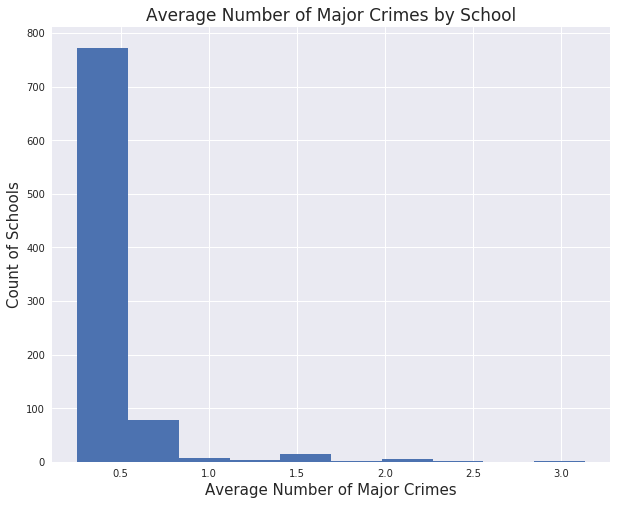

In [16]:
# plot for the distribution of 'Average number of Major crimes by school
crimeschools.groupby(crimeschools.DBN).mean().hist(column='AvgOfMajor N', figsize=(10,8))
plt.xlabel('Average Number of Major Crimes', fontsize=15)
plt.ylabel('Count of Schools', fontsize=15)
plt.title('Average Number of Major Crimes by School', fontsize=17)

#### Figure 1: The data is sourced from the 2010 - 2016 School Safety Report. The Report is produced by New York City Police Department (NYPD) and includes crime data from incidents that occur in New York City public schools. The buildings are grouped by their population and the average crime is calculated among the buildings who fall into the same group. The plot above is a histogram of the number of schools who have the same average number of major crimes. The majority of schools have a low average number of major crimes.

In [17]:
print(color.BOLD + 'Number of schools with an average number of major crimes greater than three is: {}'\
      .format(len(crimeschools[crimeschools['AvgOfMajor N'] > 3])))
print(color.BOLD + 'Fraction of schools with an average number of major crimes greater than three is: {:.3f}'\
      .format(len(crimeschools[crimeschools['AvgOfMajor N'] > 3]) / len(crimeschools.DBN.unique())))

Number of schools with an average number of major crimes greater than three is: 19
Fraction of schools with an average number of major crimes greater than three is: 0.010


## 2. Merge school data

### 2.1 Merge school SAT score and crime data

In [18]:
print(color.BOLD + 'Schools crime DF shape: {}'.format(crimeschools.shape))
print(color.BOLD + 'Schools SAT DF shape: {}'.format(sat.shape))

Schools crime DF shape: (6310, 13)
Schools SAT DF shape: (478, 3)


In [19]:
# merging on District, Brough, School Number (DBN)
schools = crimeschools.merge(sat, on='DBN')
schools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall
0,16K393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.692126,-73.931731,355.0,356.0
1,16K393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.692126,-73.931731,355.0,356.0
2,16K393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.692126,-73.931731,355.0,356.0
3,02M418,0.0,0.0,0.0,0.0,0.0,0.33,1.32,1.76,0.83,0.59,40.704487,-74.011556,553.0,538.0
4,02M418,0.0,0.0,0.0,0.0,0.0,0.31,1.12,1.82,0.79,0.51,40.704487,-74.011556,553.0,538.0


In [20]:
print(color.BOLD + 'Schools crime and SAT DF shape: {}'.format(schools.shape))

Schools crime and SAT DF shape: (1359, 15)


In [21]:
schools.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,1351.000000,1351.000000,1202.000000,1202.000000
mean,0.825065,3.616188,5.535248,2.300261,1.493473,0.650366,2.710940,4.686867,1.755953,1.143838,40.742543,-73.926089,415.435108,404.233222
std,1.394904,4.249601,7.079443,2.950051,2.192165,0.611113,2.806753,5.711933,1.792428,1.110120,0.081827,0.074026,65.442537,59.026226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.240000,0.710000,1.090000,0.510000,0.320000,40.508809,-74.222403,312.000000,295.666667
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,10.000000,26.000000,51.000000,21.000000,12.000000,3.330000,13.000000,34.860000,9.200000,7.170000,40.888338,-73.727535,735.000000,698.666667


#### There are NaN values in both datasets as shown in the description above. 

## 2.2 Deal with missing value

#### Knowing that schools with no crimes are not included in the data we will impute NaNs in the crime values with zero. This doesn't apply to the SAT scores. Observations of SAT scores with NaNs will be dropped.

In [22]:
# imputing NaNs with zero in the crime data only
schools.iloc[:, 1:-4] = schools.iloc[:, 1:-4].fillna(value=0)

In [23]:
schools.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1351.000000,1351.000000,1202.000000,1202.000000
mean,0.232524,1.019132,1.559971,0.648271,0.420898,0.183289,0.764010,1.320876,0.494871,0.322362,40.742543,-73.926089,415.435108,404.233222
std,0.827777,2.780044,4.505998,1.876110,1.342970,0.436722,1.924729,3.691469,1.236236,0.782092,0.081827,0.074026,65.442537,59.026226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.508809,-74.222403,312.000000,295.666667
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.270000,0.900000,1.170000,0.630000,0.410000,NaN,NaN,NaN,NaN
max,10.000000,26.000000,51.000000,21.000000,12.000000,3.330000,13.000000,34.860000,9.200000,7.170000,40.888338,-73.727535,735.000000,698.666667


In [24]:
schools.drop_duplicates(inplace=True)

In [25]:
print(color.BOLD + 'Schools crime and SAT DF shape after dropping duplicates: {}'\
      .format(schools.shape))
print(color.BOLD + 'We are left with {:.3f}% of the data after dropping duplicates'.\
      format(schools.shape[0] / 1359))

Schools crime and SAT DF shape after dropping duplicates: (725, 15)
We are left with 0.533% of the data after dropping duplicates


In [26]:
schools.dropna(inplace=True)

In [27]:
print(color.BOLD + 'Schools crime and SAT DF shape after dropping NaNs: {}'\
      .format(schools.shape))
print(color.BOLD + 'We are left with {:.3f}% of the data after dropping duplicates and NaNs'.\
      format(schools.shape[0] / 1359))

Schools crime and SAT DF shape after dropping NaNs: (648, 15)
We are left with 0.477% of the data after dropping duplicates and NaNs


In [28]:
schools.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall
0,16K393,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.692126,-73.931731,355.0,356.000000
3,02M418,0.0,0.0,0.0,0.0,0.0,0.33,1.32,1.76,0.83,0.59,40.704487,-74.011556,553.0,538.000000
4,02M418,0.0,0.0,0.0,0.0,0.0,0.31,1.12,1.82,0.79,0.51,40.704487,-74.011556,553.0,538.000000
5,02M418,0.0,0.0,0.0,0.0,0.0,0.28,1.11,1.74,0.75,0.53,40.704487,-74.011556,553.0,538.000000
9,16K594,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.680463,-73.922264,372.0,364.333333


### 2.3 Count schools in the same location

In [29]:
# gouping by location (lonlat) and counting the number of schools in that location
schools_loc = schools.groupby(['Latitude', 'Longitude']).count().reset_index()\
                            [['Latitude', 'Longitude', 'DBN']].rename(columns={'DBN' : 'No_of_schools'})
schools_loc.head()

,Latitude,Longitude,No_of_schools
0,40.528092,-74.192032,2
1,40.567873,-74.115373,3
2,40.569393,-74.107737,1
3,40.577208,-73.985953,3
4,40.580894,-73.935952,3


In [30]:
print(color.BOLD + 'The number of distinct school locations is {}'.format(schools_loc.shape[0]))
print('We notice multiple schools in the same location, so we will investigate further.')

The number of distinct school locations is 258
We notice multiple schools in the same location, so we will investigate further.


Text(0.5,1,'')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


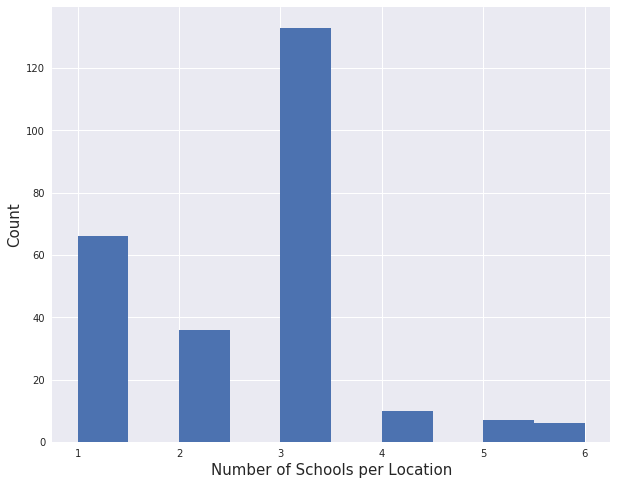

In [31]:
# plot a histogram of the distribution of schools in a cert
schools_loc.hist('No_of_schools', figsize=(10,8))
plt.xlabel('Number of Schools per Location', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('')

#### Figure 2: There are more than 120 locations having 3 schools. If compared at the level of number of schools per building, locations with three schools would show higher statistics (weight of more observations). Further investigation is done below.

In [32]:
schools_loc = schools.merge(schools_loc, on=['Latitude', 'Longitude'])
schools_loc.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall,No_of_schools
0,16K393,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.692126,-73.931731,355.0,356.000000,1
1,02M418,0.0,0.0,0.0,0.0,0.0,0.33,1.32,1.76,0.83,0.59,40.704487,-74.011556,553.0,538.000000,3
2,02M418,0.0,0.0,0.0,0.0,0.0,0.31,1.12,1.82,0.79,0.51,40.704487,-74.011556,553.0,538.000000,3
3,02M418,0.0,0.0,0.0,0.0,0.0,0.28,1.11,1.74,0.75,0.53,40.704487,-74.011556,553.0,538.000000,3
4,16K594,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.680463,-73.922264,372.0,364.333333,1


In [33]:
schools_loc.groupby('No_of_schools').mean()[['SATall', 'AvgOfMajor N', 'Major N', 'NoCrim N']]

,SATall,AvgOfMajor N,Major N,NoCrim N
No_of_schools,,,,
1,394.050505,0.006515,0.000000,0.000000
2,393.416667,0.041389,0.027778,0.375000
3,437.003342,0.583734,0.704261,4.947368
4,375.316667,0.000000,0.000000,0.000000
5,382.085714,0.000000,0.000000,0.000000
6,381.787037,0.000000,0.000000,0.000000


#### Figure 3: The table above shows that for locations with three schools we are getting the highest average of different statistics measured.

## 3. Visualize school data 

## 3.1 Plot SAT scores as a function of two crime statistics

Text(0,0.5,'SAT Average Score')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


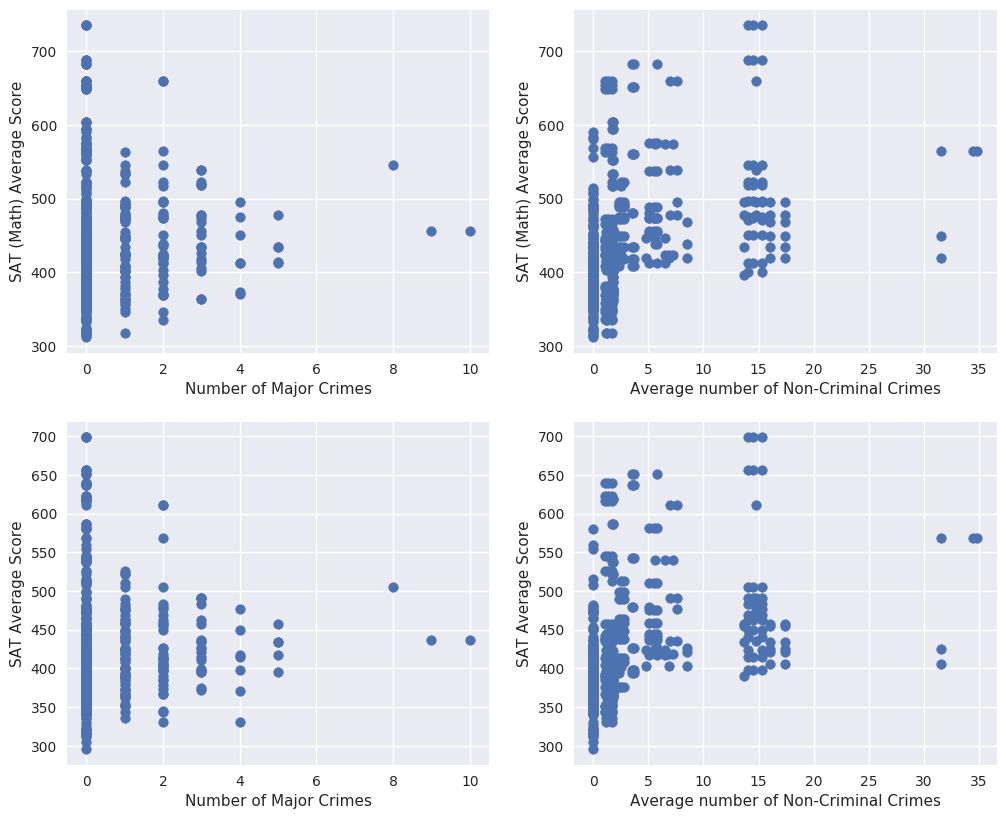

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12,10), dpi= 100)

ax[0,0].scatter(schools['Major N'], schools['SATmath'])
ax[0,1].scatter(schools['AvgOfNoCrim N'], schools['SATmath'])
ax[1,0].scatter(schools['Major N'], schools['SATall'])
ax[1,1].scatter(schools['AvgOfNoCrim N'], schools['SATall'])

ax[0,0].set_xlabel('Number of Major Crimes')
ax[0,0].set_ylabel('SAT (Math) Average Score')
#ax[0,0].set_title('SAT (Math) Average Score as a function of the Number of Major Crimes')

ax[0,1].set_xlabel('Average number of Non-Criminal Crimes')
ax[0,1].set_ylabel('SAT (Math) Average Score')

ax[1,0].set_xlabel('Number of Major Crimes')
ax[1,0].set_ylabel('SAT Average Score')

ax[1,1].set_xlabel('Average number of Non-Criminal Crimes')
ax[1,1].set_ylabel('SAT Average Score')

#### Figure 4: The analysis above is based on the 2010 - 2016 School Safety Report and the 2012 SAT results. The School Safety Report is produced by New York City Police Department (NYPD) and includes crime data from incidents that occur in New York City public schools. The schools' buildings are grouped by their population, and the average crime number is calculated among the buildings who fall into the same group. The SAT scores are calculated at the school level. 

#### To the left we have the SAT/math average score (up) and the SAT average score (down) per school plotted as a function of the number of major crimes in the school.

#### To the right we have the SAT/math average score (up) and the SAT average score (down) in a school plotted as a function of the average number of non-criminal crimes of the building group in which the school falls.

#### The scores have almost a similar behavior as a function of the same crime metric. Students who perform well on the math section tend to have a good overall performance.

#### The plots show that the range of the average and math SAT scores converges downdwards as the number of crimes increase. This suggests that on average the higher the number of crimes the lower the SAT average score is, which is intuitive. 

#### In the plots showing the average number of non-criminal crimes (right) we noticed some unique high average scores under high average crime numbers (range of average crime 14-16). This is due to the way the statistics is calculated. While some schools do not have any crimes and are expected to have high SAT scores, they fall in a building population group that has other schools with crimes.

#### The plots show the existence of three to four outliers were the cime rate is significantly high than the rest of the schools.

### 3.2 Create a geometry feature

In [35]:
# combine lat and lon to one column
schools['lonlat'] = list(zip(schools.Longitude, schools.Latitude))
# Create Point Geometry for based on lonlat column
schools['geometry'] = schools[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [36]:
# read as aa geodataframe
schools = gpd.GeoDataFrame(schools)
# set a coordinate system
schools.crs = from_epsg(4326)
schools.crs, type(schools)

({'init': 'epsg:4326', 'no_defs': True}, geopandas.geodataframe.GeoDataFrame)

In [37]:
schools.head(2)

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SATmath,SATall,lonlat,geometry
0,16K393,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.692126,-73.931731,355.0,356.0,"(-73.931731, 40.692126)",POINT (-73.931731 40.692126)
3,02M418,0.0,0.0,0.0,0.0,0.0,0.33,1.32,1.76,0.83,0.59,40.704487,-74.011556,553.0,538.0,"(-74.011556, 40.704487)",POINT (-74.011556 40.704487)


## 4. Download Hospital Inpatient Discharges (SPARCS): 2012

### 4.1 Read and subset the data on New York City only 

### This is a very big dataset, so I have attached a file with the reduced data for New York City only. You can use the attached file to read the reduced data OR uncomment the code below to read all the data (would take around 4 min). 

In [38]:
# read the data
# Url accessed and data retreived on 2018-December-12 8:00am

# discharge = pd.read_csv('https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD')
# discharge.head()

In [39]:
# subset the data to New York City only

# discharge_NYC = discharge [(discharge['Hospital County'] == 'Bronx') | (discharge['Hospital County'] == 'Kings') | \
#                        (discharge['Hospital County'] == 'Manhattan') | (discharge['Hospital County'] == 'Queens') | \
#                        (discharge['Hospital County'] == 'Richmond')]

# discharge_NYC.to_csv('discharge_NYC.csv', index=False)
!mv discharge_NYC.csv $PUIDATA/Final

discharge_NYC = pd.read_csv(PUIdata + '/Final/discharge_NYC.csv')
discharge_NYC.head()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
1,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35
2,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,...,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53
3,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,...,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92
4,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,...,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90


In [40]:
print(color.BOLD + 'Counties left after subsetting: {}'.format(discharge_NYC['Hospital County'].unique()))
print(color.BOLD + 'Number of NYC hospital inpatient discharges: {}'.format(discharge_NYC.shape[0]))
print(color.BOLD + 'Number of NYC facilities in the dataset: {}'.format(discharge_NYC['Facility ID'].unique().shape[0]))

Counties left after subsetting: ['Bronx' 'Kings' 'Manhattan' 'Queens' 'Richmond']
Number of NYC hospital inpatient discharges: 1199520
Number of NYC facilities in the dataset: 61


### 4.2 Calculate the fraction of asthma and drugs related diagnosis per facility

In [41]:
# total number of discharges per facility
discharge_NYC_T = discharge_NYC.groupby('Facility ID').count().reset_index()[['Facility ID', 'Facility Name']]\
                            .rename(columns={'Facility Name':'Number of Discharges'})
discharge_NYC_T.head()

,Facility ID,Number of Discharges
0,1164.0,4917
1,1165.0,20956
2,1168.0,15889
3,1169.0,43650
4,1172.0,23142


In [42]:
discharge_NYC_T.shape

(61, 2)

In [43]:
# total number asthma discharges per facility
discharge_NYC_A = discharge_NYC[(discharge_NYC['CCS Diagnosis Description'] == 'Asthma') | (discharge_NYC['CCS Diagnosis Description'] == 'Respiratory failure') | \
                                (discharge_NYC['CCS Diagnosis Description'] == 'insufficiency') | (discharge_NYC['CCS Diagnosis Description'] == 'arrest (adult)') | \
                                (discharge_NYC['CCS Diagnosis Description'] == 'Respiratory distress syndrome')] 

discharge_NYC_A = discharge_NYC_A.groupby('Facility ID').count().reset_index()\
                [['Facility ID', 'CCS Diagnosis Description']].rename(columns={'CCS Diagnosis Description': 'Number of Asthma Diagnosis'})

discharge_NYC_A.head()

,Facility ID,Number of Asthma Diagnosis
0,1165.0,1051
1,1168.0,494
2,1169.0,1930
3,1172.0,1699
4,1175.0,2


In [44]:
discharge_NYC_A.shape

(54, 2)

In [45]:
print(color.BOLD + 'Number of asthma related hospital cases in NYC: {}'.format(discharge_NYC_A.sum()[1]))

Number of asthma related hospital cases in NYC: 24802.0


In [46]:
# total number drugs discharges per facility
discharge_NYC_D = discharge_NYC[(discharge_NYC['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') | \
                  (discharge_NYC['CCS Diagnosis Description'] == 'Alcohol-related disorders') | \
                  (discharge_NYC['CCS Diagnosis Description'] == 'Substance-related disorders')]

discharge_NYC_D = discharge_NYC_D.groupby('Facility ID').count().reset_index()[['Facility ID', 'CCS Diagnosis Description']].rename(columns={'CCS Diagnosis Description': 'Number of Drugs Diagnosis'})

discharge_NYC_D.head()

,Facility ID,Number of Drugs Diagnosis
0,1164.0,2389
1,1165.0,1279
2,1168.0,1006
3,1169.0,323
4,1172.0,611


In [47]:
discharge_NYC_D.shape

(54, 2)

In [48]:
print(color.BOLD + 'Number of drugs related hospital cases in NYC: {}'.format(discharge_NYC_D.sum()[1]))

Number of drugs related hospital cases in NYC: 46336.0


In [49]:
# merge the numbers calculated per facility
discharge_NYC_count = discharge_NYC_T.merge(discharge_NYC_A, on='Facility ID').merge(discharge_NYC_D, on='Facility ID')
discharge_NYC_count.head()

,Facility ID,Number of Discharges,Number of Asthma Diagnosis,Number of Drugs Diagnosis
0,1165.0,20956,1051,1279
1,1168.0,15889,494,1006
2,1169.0,43650,1930,323
3,1172.0,23142,1699,611
4,1176.0,20585,822,4177


In [50]:
discharge_NYC_count.shape 

(52, 4)

In [51]:
discharge_NYC_count['Astham_Ratio'] = discharge_NYC_count['Number of Asthma Diagnosis'] / discharge_NYC_count ['Number of Discharges']
discharge_NYC_count['Drugs_Ratio'] = discharge_NYC_count['Number of Drugs Diagnosis'] / discharge_NYC_count ['Number of Discharges']

discharge_NYC_ratio = discharge_NYC_count[['Facility ID', 'Astham_Ratio', 'Drugs_Ratio']]
discharge_NYC_ratio.head()

,Facility ID,Astham_Ratio,Drugs_Ratio
0,1165.0,0.050153,0.061033
1,1168.0,0.031091,0.063314
2,1169.0,0.044215,0.007400
3,1172.0,0.073416,0.026402
4,1176.0,0.039932,0.202915


In [52]:
print(color.BOLD + 'Number of facilities with asthma and drugs observations: {}'.format(discharge_NYC_ratio.shape[0])) 

Number of facilities with asthma and drugs observations: 52


In [53]:
discharge_NYC_ratio.describe() 

,Facility ID,Astham_Ratio,Drugs_Ratio
count,52.000000,52.000000,52.000000
mean,1542.288462,0.024306,0.042966
std,519.709132,0.015344,0.056890
min,1165.000000,0.000856,0.000693
25%,1301.750000,0.012669,0.007313
50%,1447.500000,0.022877,0.012659
75%,1630.500000,0.031599,0.061603
max,3975.000000,0.073416,0.275367


### 4.3 Find the location of each facility

In [54]:
# used the attached script queryCarto.py
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql?q='

facility_loc = get_data("SELECT facility_id, facility_latitude, facility_longitude FROM nyc_facilities", 
                 sql_source=SQL_SOURCE)
facility_loc.head()

,facility_id,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772
2,6754,40.689243,-73.956383
3,1206,40.846165,-73.904655
4,1207,40.814503,-73.919029


In [55]:
facility_loc.shape

(1275, 3)

#### The data frame above has facility locations. Merging it with the discharge data frame to assign a latitiude longitude location for each of the facilities.

In [56]:
# merge
discharge_NYC_ratio_loc = discharge_NYC_ratio.merge(facility_loc, left_on='Facility ID', right_on='facility_id')
discharge_NYC_ratio_loc.head()

,Facility ID,Astham_Ratio,Drugs_Ratio,facility_id,facility_latitude,facility_longitude
0,1165.0,0.050153,0.061033,1165,40.857388,-73.846741
1,1168.0,0.031091,0.063314,1168,40.894569,-73.861420
2,1169.0,0.044215,0.007400,1169,40.879951,-73.880562
3,1172.0,0.073416,0.026402,1172,40.817661,-73.924210
4,1176.0,0.039932,0.202915,1176,40.853909,-73.891014


In [57]:
discharge_NYC_ratio_loc.shape

(49, 6)

In [58]:
print(color.BOLD + 'Some facilities were lost by the merge cause there is no location for them in the data.\n\
Number of facilities with asthma and drugs observations left after the merge: {}'.format(discharge_NYC_ratio_loc.shape[0])) 
print('Number of facilities lost: {}'.format(discharge_NYC_ratio.shape[0] - discharge_NYC_ratio_loc.shape[0]))

Some facilities were lost by the merge cause there is no location for them in the data.
Number of facilities with asthma and drugs observations left after the merge: 49
Number of facilities lost: 3


### 4.4 Create a geometry feature

In [59]:
# combine lat and lon to one column
discharge_NYC_ratio_loc['lonlat'] = list(zip(discharge_NYC_ratio_loc.facility_longitude, discharge_NYC_ratio_loc.facility_latitude))

# Create Point Geometry for based on lonlat column
discharge_NYC_ratio_loc['geometry'] = discharge_NYC_ratio_loc[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

discharge_NYC_ratio_loc.head()

,Facility ID,Astham_Ratio,Drugs_Ratio,facility_id,facility_latitude,facility_longitude,lonlat,geometry
0,1165.0,0.050153,0.061033,1165,40.857388,-73.846741,"(-73.846741, 40.857388)",POINT (-73.84674100000001 40.857388)
1,1168.0,0.031091,0.063314,1168,40.894569,-73.861420,"(-73.86142, 40.894569)",POINT (-73.86142 40.894569)
2,1169.0,0.044215,0.007400,1169,40.879951,-73.880562,"(-73.880562, 40.879951)",POINT (-73.880562 40.879951)
3,1172.0,0.073416,0.026402,1172,40.817661,-73.924210,"(-73.92421, 40.817661)",POINT (-73.92421 40.817661)
4,1176.0,0.039932,0.202915,1176,40.853909,-73.891014,"(-73.891014, 40.853909)",POINT (-73.891014 40.853909)


In [60]:
# read as a geodataframe
discharge_NYC_ratio_loc = gpd.GeoDataFrame(discharge_NYC_ratio_loc)
type(discharge_NYC_ratio_loc)

geopandas.geodataframe.GeoDataFrame

In [61]:
# assign coordinate system
discharge_NYC_ratio_loc.crs = from_epsg(4326)
discharge_NYC_ratio_loc.crs

{'init': 'epsg:4326', 'no_defs': True}

## 5. Aggregate at the PUMA level

### 5.1 Download the PUMA geodata 

In [62]:
# download
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA/Final file.gz
!mv file.gz $PUIDATA/Final
!ls -ltr $PUIDATA/Final

In [63]:
# read as a geodata frame
pumas = gpd.GeoDataFrame.from_file(PUIdata + 
                "/Final/geo_export_a19e9291-1e03-4c2f-b701-c7a21ac74ea9.shp")
pumas.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [64]:
# set coordinate system
pumas.crs = from_epsg(4326)
pumas.crs

{'init': 'epsg:4326', 'no_defs': True}

In [65]:
print(color.BOLD + 'Number of PUMAs: {}'.format(pumas.shape[0]))

Number of PUMAs: 55


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-74.283370477424782,
 -73.672229948940085,
 40.47514452607718,
 40.936503646096469)

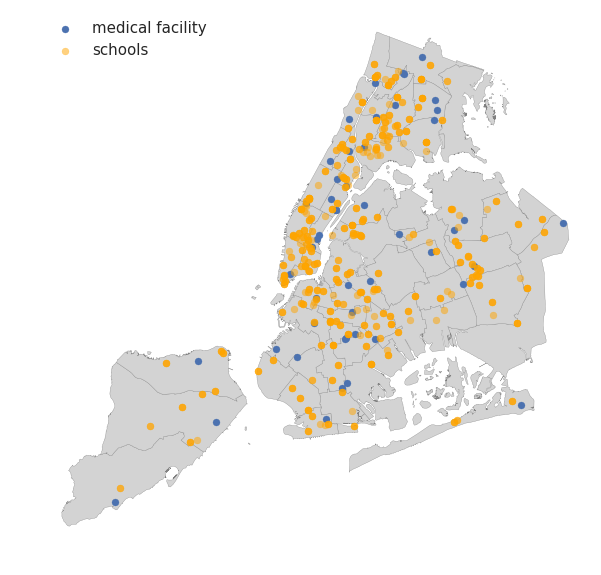

In [66]:
ax = pumas.plot(facecolor='lightgrey', edgecolor='grey', figsize=(10,10))
discharge_NYC_ratio_loc.plot(ax=ax, legend=True)
schools.plot(ax=ax, c='orange', alpha=0.5, legend=True)
ax.legend(['medical facility', 'schools'], loc=2, fontsize=15)
ax.axes.set_aspect('auto')
ax.axis('off')

#### Figure 5: A map of NYC Public Use Microdata Areas (PUMAs). According to NYC OpenData portal PUMAs are statistical geographic areas defined for the dissemination of Public Use Microdata Sample (PUMS) data. The total number of PUMAs is 55, and they have a minimum population of 100,000. The location of schools (orange) and the location of medical facilities (blue) are plotted over the map.

### 5.2 Spatially join the PUMA geodata with hospital locations

In [67]:
# convert coordinates to state plane coordinate system
pumas.to_crs(epsg=2263, inplace=True)
discharge_NYC_ratio_loc.to_crs(epsg=2263, inplace=True)
schools.to_crs(epsg=2263, inplace=True)
pumas.crs, discharge_NYC_ratio_loc.crs, schools.crs

({'init': 'epsg:2263', 'no_defs': True},
 {'init': 'epsg:2263', 'no_defs': True},
 {'init': 'epsg:2263', 'no_defs': True})

In [68]:
# spatial join 
puma_hospital = gpd.sjoin(pumas, discharge_NYC_ratio_loc, how='left').groupby('puma')[['Astham_Ratio', 'Drugs_Ratio']].mean().reset_index()
puma_hospital.head()

,puma,Astham_Ratio,Drugs_Ratio
0,3701,NaN,NaN
1,3702,0.031091,0.063314
2,3703,NaN,NaN
3,3704,0.033268,0.032269
4,3705,0.039932,0.202915


In [69]:
puma_hospital.shape

(55, 3)

### 5.3 Spatially join the PUMA geodata with school locations

In [70]:
# spatial join
puma_school = gpd.sjoin(pumas, schools, how='left').groupby('puma')[['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N', \
                                                                     'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', \
                                                                     'AvgOfVio N', 'SATmath', 'SATall']].mean().reset_index()
puma_school.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall
0,3701,0.052632,1.421053,2.947368,0.789474,0.263158,0.501579,2.295263,3.897895,1.413684,0.945263,488.157895,473.824561
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741
2,3703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.400000,391.400000
3,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000
4,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559


In [71]:
puma_school.shape

(55, 13)

### Merge the two datasets 

In [72]:
alldata = puma_school.merge(puma_hospital, on='puma').dropna()
alldata.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,Astham_Ratio,Drugs_Ratio
1,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.063314
3,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.033268,0.032269
4,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.039932,0.202915
6,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.013583
8,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.044483,0.003671


In [73]:
print(color.BOLD + 'Some PUMAs were lost in the merge because there were no observations in them.')
print('Numeber of PUMAs left after spatial join and merge: {}'.format(alldata.shape[0]))

Some PUMAs were lost in the merge because there were no observations in them.
Numeber of PUMAs left after spatial join and merge: 36


# Part Two: Exploratory Analysis and Modeling

## 6. Check for collinearity and covariance 

### 6.1 SAT features

Text(0,0.5,'Average of all SAT Scores')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


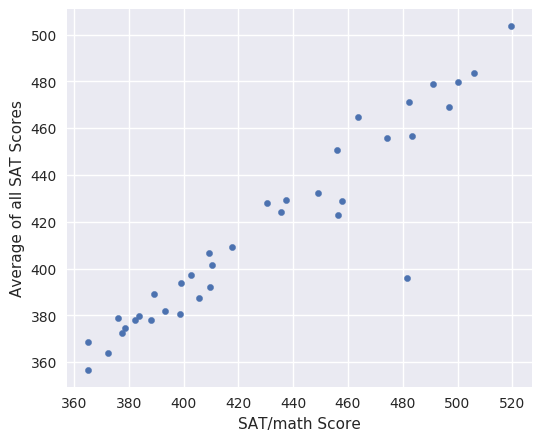

In [74]:
fig1, ax = plt.subplots(figsize=(6,5), dpi=100)
alldata.plot('SATmath', 'SATall', kind='scatter', ax=ax)
plt.xlabel('SAT/math Score')
plt.ylabel('Average of all SAT Scores')

#### Figure 6: The plot is based on the data from the same source mentioned above. It shows how the math SAT score has a strong linear relationship with the average score of the three SAT grades. There is one outlier point. However, we will consider the variables covariant and choose the average of scores for further analysis.

### 6.2 SAT feature against three crime features

Text(0.5,0,'Mean of Average Number of Major Crimes per PUMA')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


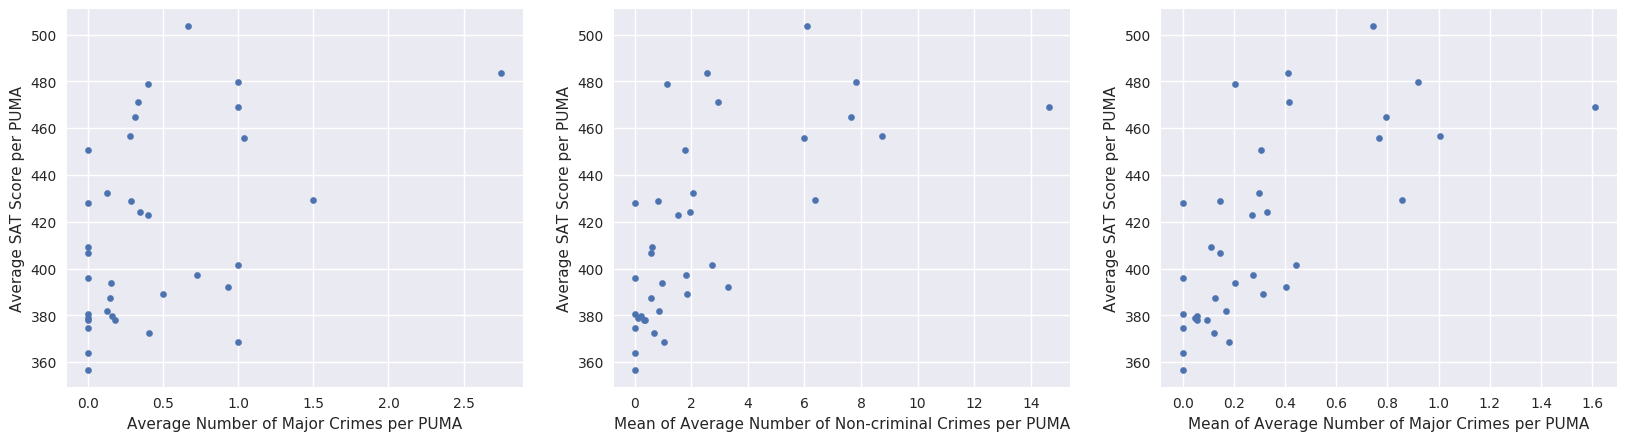

In [75]:
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), dpi=100)

alldata.plot('Major N', 'SATall', kind='scatter', ax=ax1)
alldata.plot('AvgOfNoCrim N', 'SATall', kind='scatter', ax=ax2)
alldata.plot('AvgOfMajor N', 'SATall', kind='scatter', ax=ax3)

ax1.set_ylabel('Average SAT Score per PUMA')
ax2.set_ylabel('Average SAT Score per PUMA')
ax3.set_ylabel('Average SAT Score per PUMA')

ax1.set_xlabel('Average Number of Major Crimes per PUMA')
ax2.set_xlabel('Mean of Average Number of Non-criminal Crimes per PUMA')
ax3.set_xlabel('Mean of Average Number of Major Crimes per PUMA')

#### Figure 7: The plots are based on data from the same sources mentioned above. The plots show how the chosen SAT feature (average of all scores per PUMA) vary with three types of crimes. From left to right the feature is plotted against the average number of major crimes per puma, the mean of average number of non-criminal crimes per PUMA, and the mean of average number of major crimes per PUMA. All the plots show a variability of scores at low crime level. However, in cases were the crime is high, only high scores are observed. This may suggest that in PUMAs were there is high crime, only serious students tend to apply for the SAT exam. It looks like in such locations only students who excel in their studies (shown by a high SAT score) tend to move higher with their studies, while others may be dropping school.

### SAT feature against two health features 

Text(0.5,0,'Average Ratio of Drugs Related Hospitalizations per PUMA')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


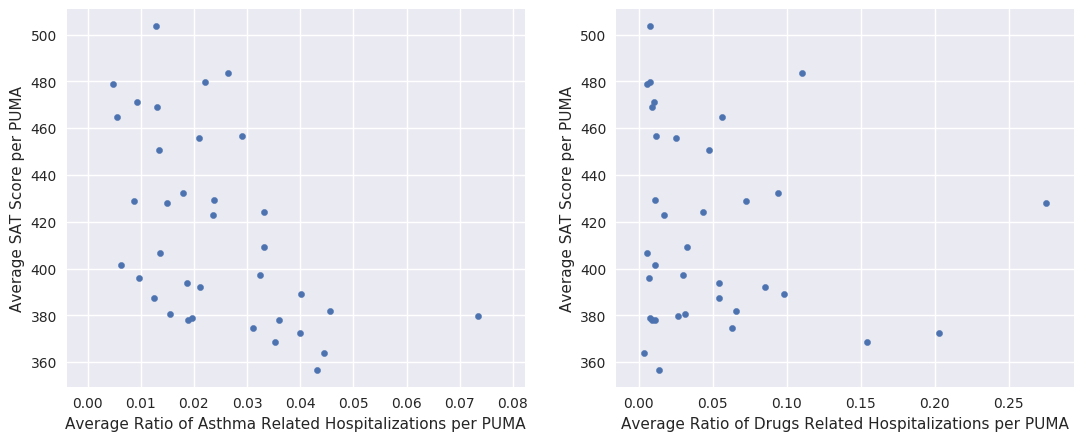

In [76]:
fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5), dpi=100)
alldata.plot('Astham_Ratio', 'SATall', kind='scatter', ax=ax1)
alldata.plot('Drugs_Ratio', 'SATall', kind='scatter', ax=ax2)

ax1.set_ylabel('Average SAT Score per PUMA')
ax2.set_ylabel('Average SAT Score per PUMA')

ax1.set_xlabel('Average Ratio of Asthma Related Hospitalizations per PUMA')
ax2.set_xlabel('Average Ratio of Drugs Related Hospitalizations per PUMA')

#### Figure 8: The plots are based on data from the sources mentioned above. The plots show how the chosen SAT feature (average of all scores per PUMA) vary under two types of discharge diagnosis. From left to right the feature is plotted against the average ratio of asthma related hospitalizations per puma, and the average ratio of drugs rleated hospitalizations per PUMA. A wide range of SAT scores is observed under low asthma and drugs related hospitalizations ratios. In addition, we observe that the range of average ratio of drugs related hospitalization is wider than that of asthma (i.e there are more drugs related observations than those of asthma). Surprisingly, in PUMAs showing the same ratio of both hospitalizations type (~0.04), the range of SAT score is wider for drugs (~380-470) than it is for asthma (~360-400). This suggests that the asthma ratio has a stronger effect on SAT performance when compared to drugs.

## Correlation matrix

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


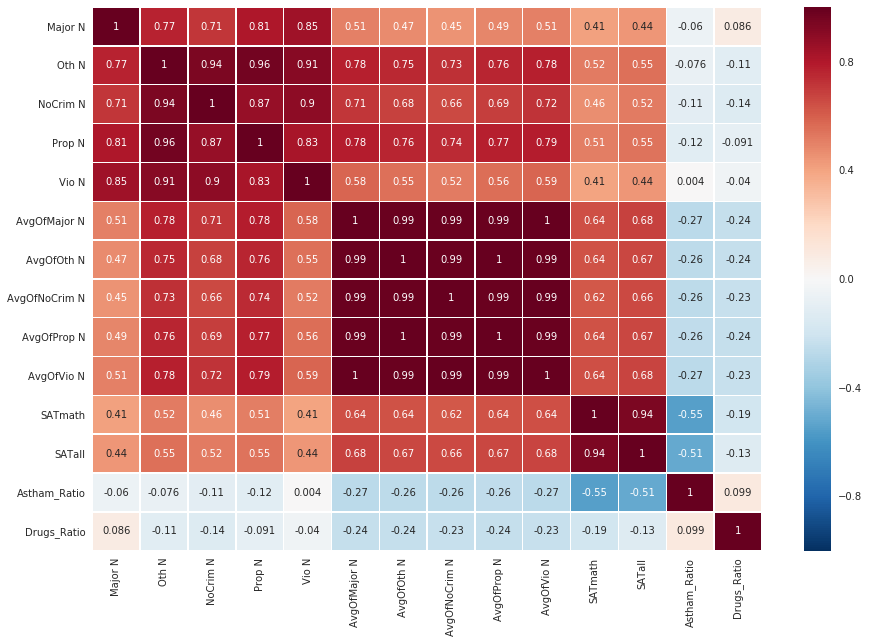

In [77]:
corr_mat = alldata.iloc[:, 1:].corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr_mat, annot=True, linewidths=0.4, annot_kws={"size": 10}, ax=ax)

#### Figure 9: This is a correlation matrix of all the variables in our data. The darker the red the higher the positive correlation is, and the darker the blue the higher the negative correlation is. Light red and blue colors denote low correlation. The daigonal shows the correlation of the variable with itself. The two SAT scores show high correlation reinforcing our decision to choose one of them for further analysis. The average number of different crime types show a higher positive correlation with the with SAT scores than the number of crimes. Health related variables show a low negative correlation with SAT scores. It is important to note the high correlation between the different crime features. This high covariance between features is a disadvantage for our analysis.

## Cluster matrix 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

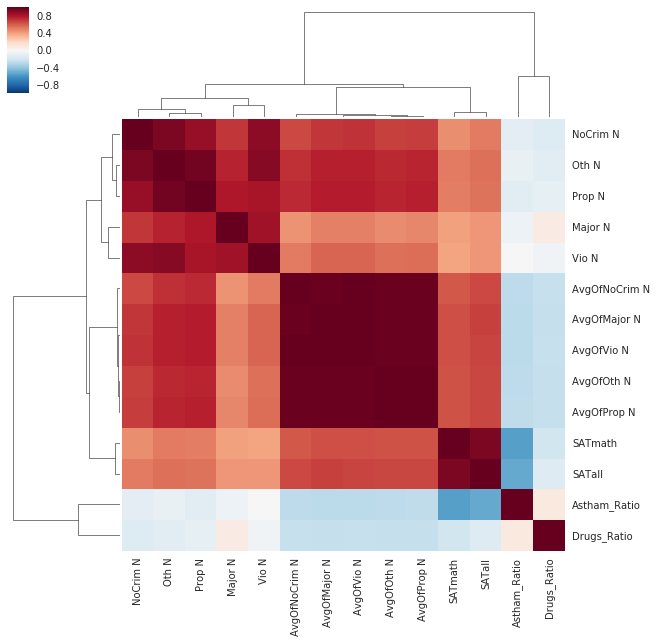

In [78]:
fig4 = sns.clustermap(corr_mat, row_cluster=True, col_cluster=True, figsize=(10, 10))
plt.setp(fig4.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig4.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

#### Figure 10: Similar to figure 9 the illustration above is a correlation matrix with an added feature showing independent clustering for each variable. 

## 7. Mapping

In [79]:
# merging the puma geodata with the school and health data
alldata_geo = pumas.merge(alldata, on='puma')
alldata_geo.head()

,puma,shape_area,shape_leng,geometry,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,Astham_Ratio,Drugs_Ratio
0,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.031091,0.063314
1,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.033268,0.032269
2,4016,1.207135e+08,109477.751817,"POLYGON ((999782.7833862281 162246.8424071733,...",1.000000,5.571429,9.857143,2.142857,3.142857,0.920000,4.492857,7.827143,2.720000,1.757143,500.000000,479.809524,0.022067,0.007400
3,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.039932,0.202915
4,3707,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.043208,0.013583


In [80]:
alldata_geo.shape

(36, 18)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Average Fraction of Drugs Related Diagnoses PUMA')

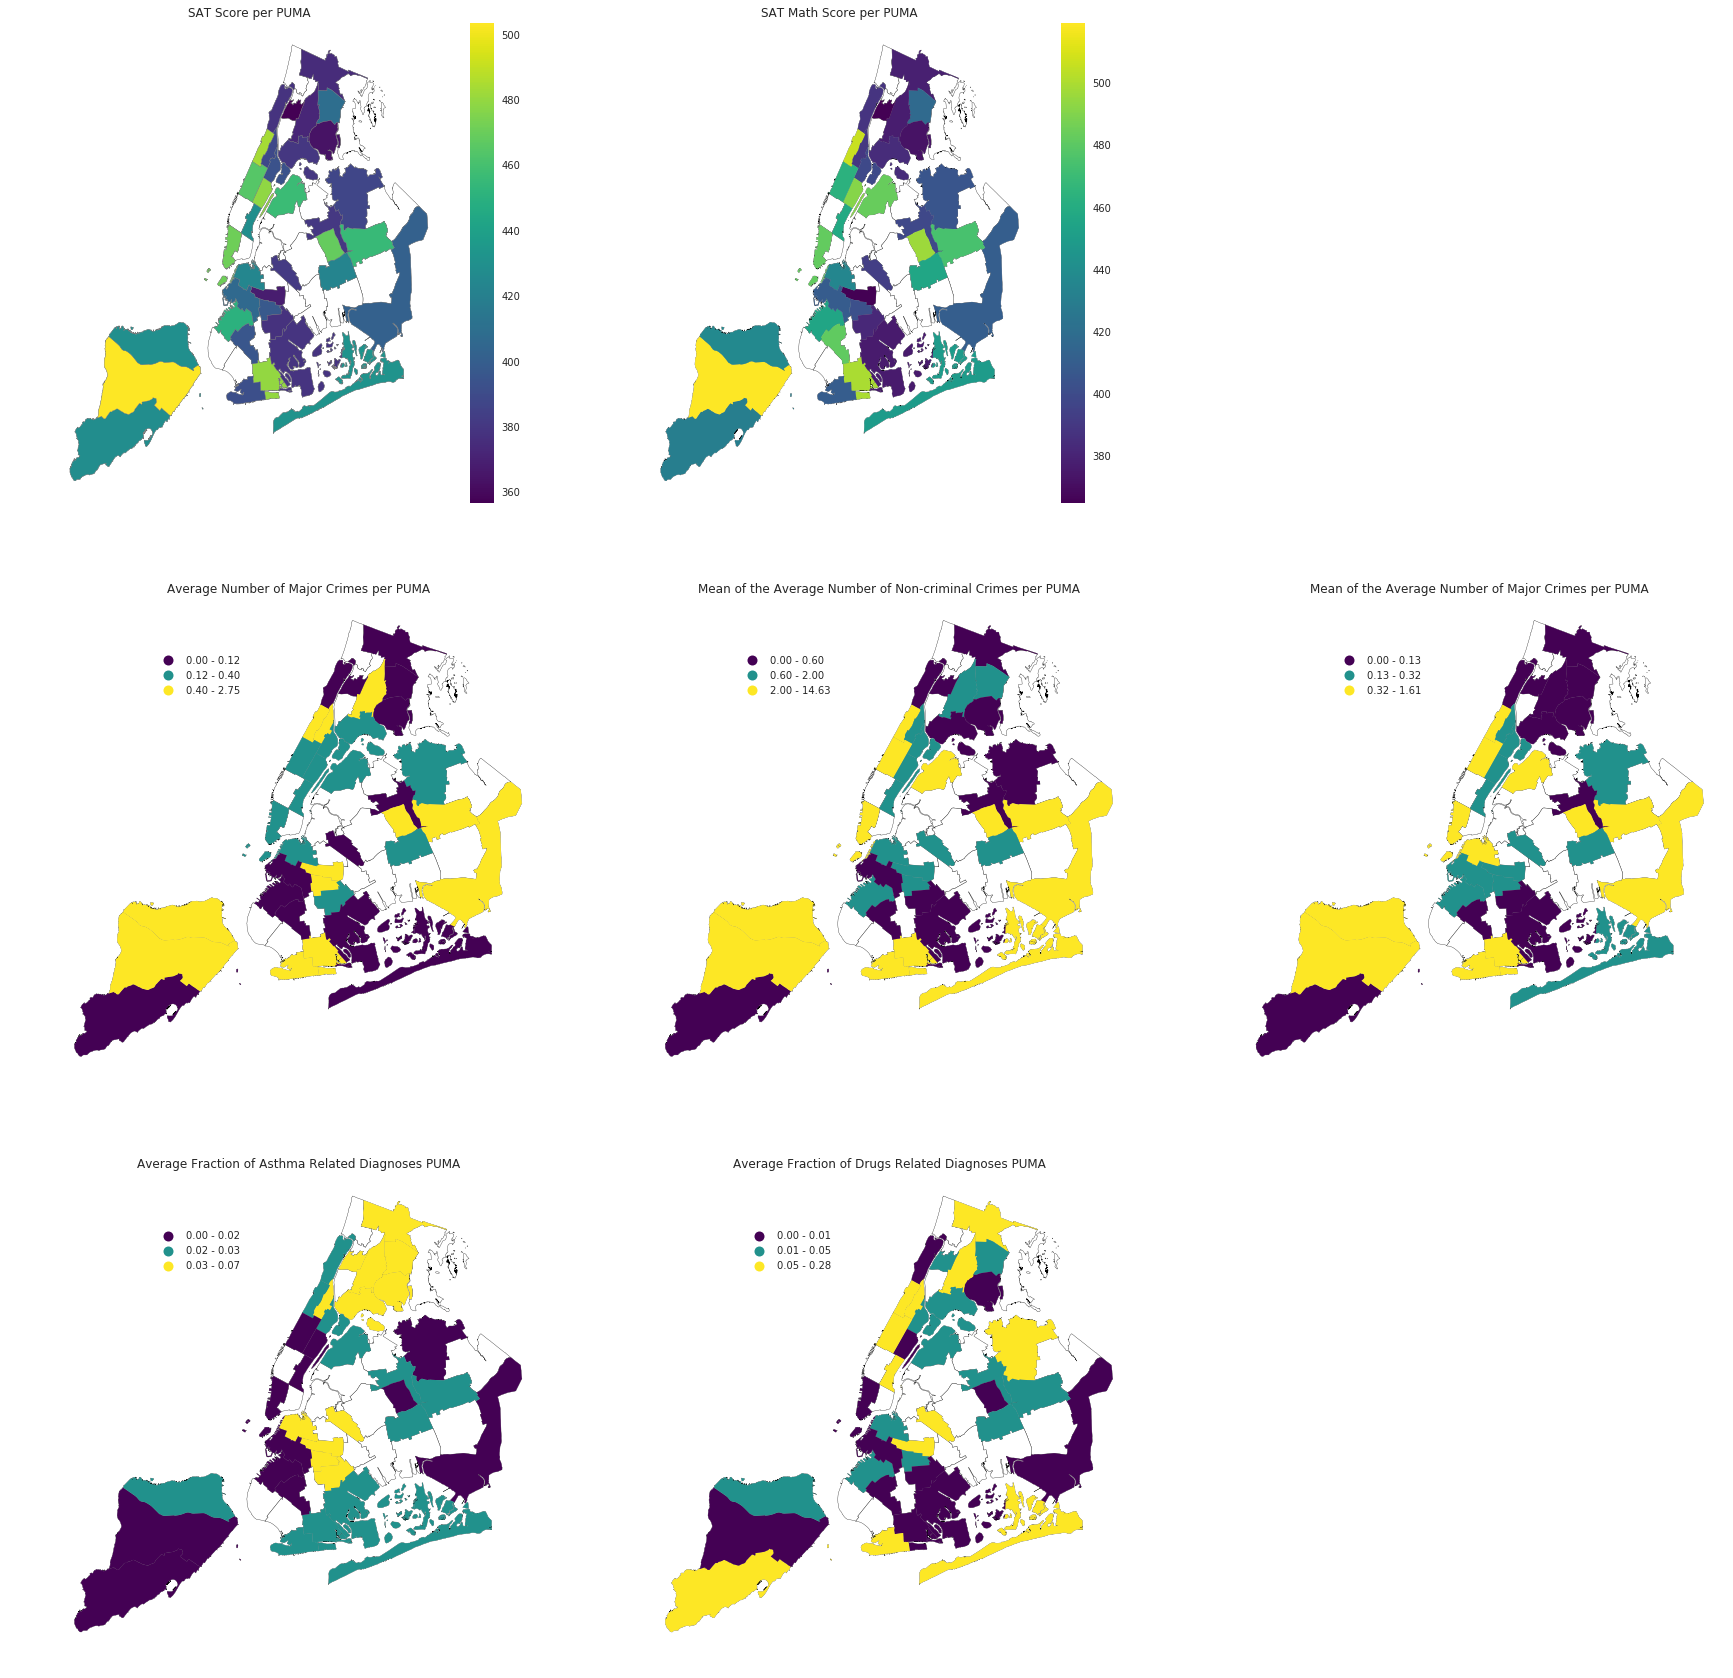

In [81]:
fig5 = plt.figure(figsize=(30,30))

# SAT
ax1 = fig5.add_subplot(331)
pumas.plot(ax=ax1, color='w', edgecolor='k')
alldata_geo.plot(column='SATall', cmap='viridis', ax=ax1, edgecolor='grey', legend=True)
ax1.axis('off')
ax1.axes.set_aspect('auto')
ax1.set_title('SAT Score per PUMA')

ax2 = fig5.add_subplot(332)
pumas.plot(ax=ax2, color='w', edgecolor='k')
alldata_geo.plot(column='SATmath', cmap='viridis', ax=ax2, legend=True)
ax2.axis('off')
ax2.axes.set_aspect('auto')
ax2.set_title('SAT Math Score per PUMA')

# Crime
ax4 = fig5.add_subplot(334)
pumas.plot(ax=ax4, color='w', edgecolor='k')
alldata_geo.plot(column='Major N', cmap='viridis', ax=ax4, scheme='quantiles', k=3, legend=True)
ax4.axis('off')
ax4.axes.set_aspect('auto')
ax4.get_legend().set_bbox_to_anchor((.4, .9))
ax4.set_title('Average Number of Major Crimes per PUMA')

ax5 = fig5.add_subplot(335)
pumas.plot(ax=ax5, color='w', edgecolor='k')
alldata_geo.plot(column='AvgOfNoCrim N', cmap='viridis', ax=ax5, scheme='quantiles', k=3, legend=True)
ax5.axis('off')
ax5.axes.set_aspect('auto')
ax5.get_legend().set_bbox_to_anchor((.4, .9))
ax5.set_title('Mean of the Average Number of Non-criminal Crimes per PUMA')

ax6 = fig5.add_subplot(336)
pumas.plot(ax=ax6, color='w', edgecolor='k')
alldata_geo.plot(column='AvgOfMajor N', cmap='viridis', ax=ax6, scheme='quantiles', k=3, legend=True)
ax6.axis('off')
ax6.axes.set_aspect('auto')
ax6.get_legend().set_bbox_to_anchor((.4, .9))
ax6.set_title('Mean of the Average Number of Major Crimes per PUMA')

# health
ax7 = fig5.add_subplot(337)
pumas.plot(ax=ax7, color='w', edgecolor='k')
alldata_geo.plot(column='Astham_Ratio', cmap='viridis', ax=ax7, scheme='quantiles', k=3, legend=True)
ax7.axis('off')
ax7.axes.set_aspect('auto')
ax7.get_legend().set_bbox_to_anchor((.4, .9))
ax7.set_title('Average Fraction of Asthma Related Diagnoses PUMA')

ax8 = fig5.add_subplot(338)
pumas.plot(ax=ax8, color='w', edgecolor='k')
alldata_geo.plot(column='Drugs_Ratio', cmap='viridis', ax=ax8, scheme='quantiles', k=3, legend=True)
ax8.axis('off')
ax8.axes.set_aspect('auto')
ax8.get_legend().set_bbox_to_anchor((.4, .9))
ax8.set_title('Average Fraction of Drugs Related Diagnoses PUMA')

#### Figure 11: Choropleths of New York City colorcoded according to the distribution of the different variables under study. The first row of plots shows the two SAT features per PUMA. The second row shows three crime features: the average number of major crimes per PUMA, the mean of average number of non-criminal crimes per PUMA, and the mean of average number of major crimes per PUMA. The third row shows the asthma and drugs ratios per PUMA. Yellow denotes high values, and white denotes PUMAs not included in the study. An outlier (yellow) PUMA in Staten Island shows the highest SAT scores. This same PUMA is also showing high crime averages in all three plotted types. However, it shows a very low asthma and drug related issues. Other yellow PUMAs in the crime plots (mainly in east Queens and south brooklyn) correspond to relatively low SAT scores. High asthma and drugs ratios is the Bronx and north Queens show low SAT scores.

## 8. Linear modelling

### 8.1 Multivariate linear model using crime features (all ten)

#### Preprocessing the data before modelling by standardizing the feartures to be able to compare them later

In [82]:
# creating a new data frame of the processed(scaled) data while dropping puma
alldata_proc = pd.DataFrame(columns=alldata.iloc[:, 1:].columns, data=preprocessing.scale(alldata.iloc[:, 1:]))

# stripping the N to avoid spaces in column names
alldata_proc.columns = alldata_proc.columns.str.rstrip(' N')

alldata_proc.head()

,Major,Oth,NoCrim,Prop,Vio,AvgOfMajor,AvgOfOth,AvgOfNoCrim,AvgOfProp,AvgOfVio,SATmath,SATall,Astham_Ratio,Drugs_Ratio
0,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.108271,-1.025939,0.482432,0.240826
1,-0.785348,0.324183,-0.334674,0.105177,0.245558,-0.617695,-0.565271,-0.577461,-0.575915,-0.592757,-0.247943,-0.165577,0.634782,-0.287559
2,-0.057931,0.116952,0.207403,-0.190236,0.302524,-0.576952,-0.538834,-0.551243,-0.547694,-0.558402,-1.129957,-1.080542,1.101009,2.616807
3,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.405819,-1.474018,1.330240,-0.605590
4,-0.785348,-0.851134,-0.794531,-0.841542,-0.808317,-0.923409,-0.810732,-0.765379,-0.852250,-0.869725,-1.246679,-1.291914,1.419406,-0.774296


In [83]:
alldata.shape

(36, 15)

In [84]:
alldata_proc.describe()

,Major,Oth,NoCrim,Prop,Vio,AvgOfMajor,AvgOfOth,AvgOfNoCrim,AvgOfProp,AvgOfVio,SATmath,SATall,Astham_Ratio,Drugs_Ratio
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01
mean,4.009139e-17,3.392348e-17,-3.083953e-17,-1.326100e-16,4.317534e-17,-1.888921e-17,-8.827815e-17,-9.097661e-17,-6.900344e-17,-8.596519e-17,-4.996004e-16,6.753857e-16,-2.806397e-16,-6.476301e-17
std,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00,1.014185e+00
min,-7.853476e-01,-8.511341e-01,-7.945310e-01,-8.415420e-01,-8.083167e-01,-9.234089e-01,-8.107317e-01,-7.653787e-01,-8.522499e-01,-8.697251e-01,-1.405819e+00,-1.474018e+00,-1.351675e+00,-7.742959e-01
25%,-7.853476e-01,-7.418770e-01,-7.313638e-01,-6.801694e-01,-8.083167e-01,-6.855781e-01,-6.775057e-01,-6.518148e-01,-6.733022e-01,-7.209233e-01,-8.796007e-01,-8.827092e-01,-7.562242e-01,-6.641403e-01
50%,-2.798126e-01,-2.354917e-01,-3.382111e-01,-2.464670e-01,-3.999403e-01,-3.493909e-01,-3.810024e-01,-4.236109e-01,-3.604910e-01,-3.783776e-01,-3.281226e-01,-2.911669e-01,-2.212295e-01,-3.561526e-01
75%,4.357685e-01,2.934010e-01,2.603895e-01,2.600952e-01,3.321939e-01,2.323892e-01,1.530274e-01,1.035936e-01,2.064974e-01,2.275002e-01,8.170845e-01,9.047827e-01,6.271356e-01,2.498266e-01
max,4.148958e+00,3.588953e+00,4.063448e+00,3.289597e+00,3.231536e+00,3.602564e+00,4.052291e+00,3.808194e+00,4.038627e+00,3.630249e+00,1.981836e+00,2.195872e+00,3.443721e+00,3.849931e+00


#### There are no infinity or zeros

In [85]:
m1 = smf.ols(formula='SATall ~ Major + Oth + NoCrim + Prop + Vio + AvgOfMajor + AvgOfOth + \
        AvgOfNoCrim + AvgOfProp + AvgOfVio', data=alldata_proc).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     3.067
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0111
Time:                        10:41:05   Log-Likelihood:                -36.671
No. Observations:                  36   AIC:                             95.34
Df Residuals:                      25   BIC:                             112.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    6.106e-16      0.134   4.56e-15      1.000        -0.276     0.276
Major           0.9304      0.564      1.649      0.112        -0.232     2.093
Oth             2.4675      1.780      1.386      0.178        -1.199     6.134
NoCrim         -0.1731      0.510     -0.339      0.737        -1.224     0.878
Prop           -2.0212      1.306     -1.547      0.134        -4.712     0.669
Vio            -1.2793      0.897     -1.425      0.166        -3.128     0.569
AvgOfMajor      1.1242      4.424      0.254      0.801        -7.988    10.236
AvgOfOth       -0.4840      8.565     -0.057      0.955       -18.123    17.155
AvgOfNoCrim    -1.1748      2.223     -0.528      0.602        -5.754     3.405
AvgOfProp       0.2010      7.572      0.027      0.979       -15.395    15.797
AvgOfVio        1.0746      4.877      0.220      0.827        -8.970    11.119
==============================================================================
Omnibus:                        6.573   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                5.160
Skew:                           0.868   Prob(JB):                       0.0758
Kurtosis:                       3.656   Cond. No.                         265.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 8.2 Multivariate linear model using crime and health features

In [86]:
m2 = smf.ols(formula='SATall ~ Major + Oth + NoCrim + Prop + Vio + AvgOfMajor + AvgOfOth + \
        AvgOfNoCrim + AvgOfProp + AvgOfVio + Astham_Ratio + Drugs_Ratio', data=alldata_proc).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     3.979
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00218
Time:                        10:41:05   Log-Likelihood:                -30.857
No. Observations:                  36   AIC:                             87.71
Df Residuals:                      23   BIC:                             108.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     6.106e-16      0.119   5.14e-15      1.000        -0.246     0.246
Major            0.9125      0.519      1.757      0.092        -0.162     1.987
Oth              2.9914      1.614      1.854      0.077        -0.347     6.330
NoCrim          -0.3277      0.460     -0.713      0.483        -1.279     0.623
Prop            -2.2184      1.179     -1.881      0.073        -4.658     0.221
Vio             -1.2084      0.808     -1.495      0.148        -2.880     0.464
AvgOfMajor       1.7536      4.040      0.434      0.668        -6.604    10.111
AvgOfOth        -0.1696      7.727     -0.022      0.983       -16.154    15.815
AvgOfNoCrim     -0.2604      2.031     -0.128      0.899        -4.461     3.940
AvgOfProp        0.0490      6.822      0.007      0.994       -14.063    14.161
AvgOfVio        -0.9045      4.441     -0.204      0.840       -10.091     8.282
Astham_Ratio    -0.3958      0.134     -2.961      0.007        -0.672    -0.119
Drugs_Ratio      0.0006      0.133      0.005      0.996        -0.274     0.275
==============================================================================
Omnibus:                        1.682   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.230
Skew:                           0.452   Prob(JB):                        0.541
Kurtosis:                       2.941   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Figure 12: The two tables above are two summaries of two models. The first model (m1) uses only crime data to predict SAT average score, while the second one (m2) uses crime and health data. Adding the health variables enhanced the performance of our model in terms of r-squared. While m1 is able to predict 50% of the variation in our data, m2 predicts 67%. The average of major crimes, other crimes, property crimes and violent crimes have the highest confidence intervals. 

## 9. Compare the two linear models

#### Likelihood ratio at alpha level 0.05

In [87]:
# set an alpha level
alpha = 0.05

# calculate liklihood ratio
print (color.BOLD + 'Likelihood Ratio : ', -2 * (m1.llf - (m2.llf)))

# use statsmodels to calculate likelihood ratio
lr_stat, p_value, df_diff = m2.compare_lr_test(m1)
print('\nUsing Statsmodels:\nLikelihood ratio test statistic = {}\np-value = {}\n\
difference in df between models = {}'.format(lr_stat, p_value, df_diff))

if p_value < alpha: 
    print ('\np_value = {:.3f} < alpha {}. Reject the Null hypothesis that the restricted model\
    (crimes only) is better than the second model (crime with health)'.format(p_value, alpha))
else:
    print ('\np_value = {:.3f} > alpha {}. The Null hypothesis that the restricted model\
    (crimes only) is better than the second model (crime with health) holds'.format(p_value, alpha))

Likelihood Ratio :  11.6282763421

Using Statsmodels:
Likelihood ratio test statistic = 11.628276342059102
p-value = 0.0029850518233572945
difference in df between models = 2.0

p_value = 0.003 < alpha 0.05. Reject the Null hypothesis that the restricted model    (crimes only) is better than the second model (crime with health)


#### Chi square

In [88]:
# function that calculates chi squared
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [89]:
# degrees of freedom = number of observations - number of model parameters
# for m1
df1 = m1.df_resid
#for m2
df2 = m2.df_resid

chisq1 = chi2(alldata_proc.SATall, m1.predict()) / float(df1)
chisq2 = chi2(alldata_proc.SATall, m2.predict()) / float(df2)

print(color.BOLD + 'Model 1 chi square: {:.3f}'.format(chisq1)) 
print(color.BOLD + 'Model 2 chi square: {:.3f}'.format(chisq2)) 

if chisq1 > chisq2:
    print('\nModel 2 has a better goodness of fit than model 1 (restricted model).')
else:
    print('\nModel 1 (restricted model) has a better goodness of fit than model 2.')

Model 1 chi square: 0.647
Model 2 chi square: 0.509

Model 2 has a better goodness of fit than model 1 (restricted model).


## 10. Random forests regression on school data only

### 10.1 Using the ten crime features 

In [90]:
# create the features and the target variable
X = alldata_proc.iloc[:, :10]     # crime
y = ravel(alldata_proc.iloc[:, 11:12])   # SAT score

In [91]:
# split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=42)

# fit 'rf' to the training set
rf.fit(X_train, y_train)

# predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

### 11.2 Evaluate the model's performance 

In [92]:
# evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred) ** 1/2 #RMSE is the square root of MSE

# evaluate the coefficient of determination R^2 of the prediction on testing data
r2_test = rf.score(X_test, y_test)

# evaluate the coefficient of determination R^2 of the prediction on training data
r2_train = rf.score(X_train, y_train)

print(color.BOLD + 'Test set RMSE of the random forests model: {:.2f}'.format(rmse_test))
print(color.BOLD + 'Test set R-squared of the random forests model: {:.2f}'.format(r2_test))
print(color.BOLD + 'Train set R-squared of the random forests model: {:.2f}'.format(r2_train))

Test set RMSE of the random forests model: 0.28
Test set R-squared of the random forests model: 0.25
Train set R-squared of the random forests model: 0.83


#### When the variation due to linear trend (r-squared) is larger than the variation due to residuals (RMSE), the model is better. This is not achieved in the results above (RMSE > R-squared). Moreover R-squared is higher on the training data, which is an indication of overfitting.

### 10.3 Feature importance 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


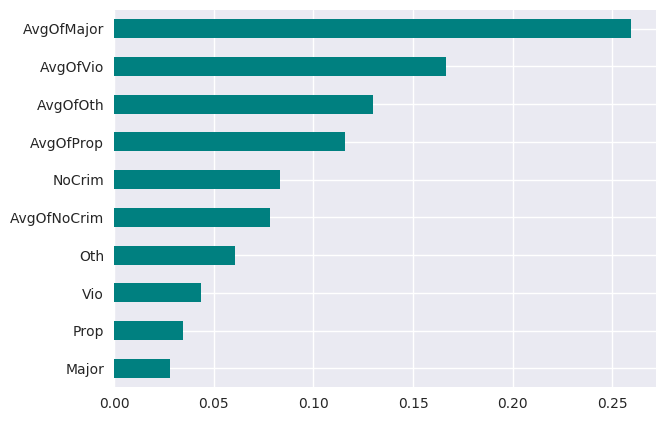

In [93]:
# create a pd.Series of feature importances
importances_rf = pd.Series(rf.feature_importances_, index=X.columns)

# sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# make a horizontal bar plot
fig6, ax = plt.subplots(figsize=(7,5), dpi=100)
sorted_importances_rf.plot(kind='barh', color='teal', ax=ax)

#### Figure 13: The graph above shows that the average of major crimes, violent crimes, other crimes are the most important features. This was reflected by the linear model results as well. 

## 11. Random forests regression on school and health data

### 11.1 Using the three most predictive features from school crimes and the health features

In [94]:
# create the features and the target variable
X = alldata_proc[['AvgOfMajor', 'AvgOfVio', 'AvgOfOth', 'Astham_Ratio', 'Drugs_Ratio']]     # 3 most important crime features & health 
y = ravel(alldata_proc.iloc[:, 11:12])   # SAT score

In [95]:
# split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# instantiate a random forests regressor 'rf2' 400 estimators
rf2 = RandomForestRegressor(n_estimators=400, min_samples_leaf=0.12, random_state=42)

# fit 'rf2' to the training set
rf2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=0.12,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

### 11.2 Evaluate the model's performance 

In [96]:
# predict the test set labels 'y_pred'
y_pred = rf2.predict(X_test)

# evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred) ** 1/2 #RMSE is the square root of MSE

# evaluate the coefficient of determination R^2 of the prediction
r2_test = rf2.score(X_test, y_test)

# evaluate the coefficient of determination R^2 of the prediction on training data
r2_train = rf2.score(X_train, y_train)

print(color.BOLD + 'Test set RMSE of the random forests model: {:.2f}'.format(rmse_test))
print(color.BOLD + 'Test set R^2 of the random forests model: {:.2f}'.format(r2_test))
print(color.BOLD + 'Train set R-squared of the random forests model: {:.2f}'.format(r2_train))

Test set RMSE of the random forests model: 0.21
Test set R^2 of the random forests model: 0.43
Train set R-squared of the random forests model: 0.92


#### This model adds the health data to the previously used crime data. When the variation due to linear trend (r-squared) is larger than the variation due to residuals (RMSE), the model is better. This is achieved in the results above (RMSE < R-squared). This model is performing better than the previous one. This model also shows an R-squared higher on the training data, which is an indication of overfitting.

### 11.3 Feature importance

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


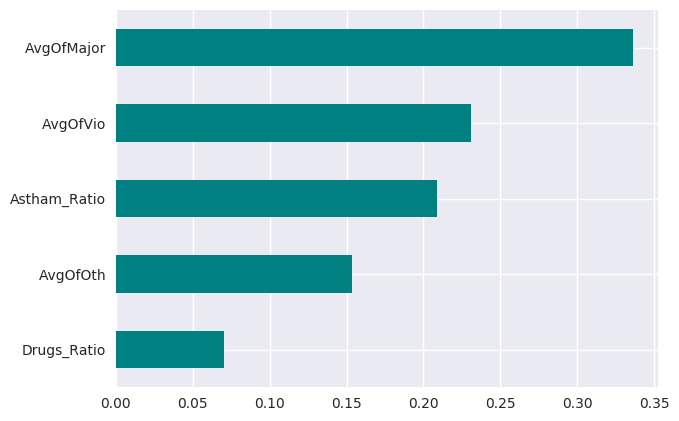

In [97]:
# create a pd.Series of feature importances
importances_rf2 = pd.Series(rf2.feature_importances_, index=X.columns)

# sort importances_rf2
sorted_importances_rf2 = importances_rf2.sort_values()

# make a horizontal bar plot
fig6, ax = plt.subplots(figsize=(7,5), dpi=100)
sorted_importances_rf2.plot(kind='barh', color='teal', ax=ax)# create a pd.Series of feature importances

#### Figure 14: The graph above shows that the average of major crimes, violent crimes, and asthma ratio are the most important features. Asthma shows more importance than drugs in predicting SAT values, something that was noticed when checking for colinearity in part 6.2.

### Conclusion:

#### In part one we collected and wrangled the NYC public schools crime, SAT scores along with the discharge data related to asthma and drugs. Then the data was spatially joined and aggregated at the PUMA level. In part two we tested for correlation between features, and we ran multivariate linear regressions and random forests models to capture the relation between crime/health features and SAT scores. If we base our conclusion on the value of r-squared across the four models, the complex linear regression model (m2) is the one that best expllains our data.

### Limitations:

#### 1. Modeling limitaiton: An obvious limitation for all four models is the existance of highly correlated features given that they are directly linearly related (e.g. Number of Major Crimes & Averag Of Major Crimes).
#### 2. Data limitation: not all NYC PUMAs were included in this analysis. Including more PUMAs would make the data and our results more robust.   
#### 3. Feature limitation: socioeconomic features could have been considered to enhance the diversity of the variables and the predictive power of the model.  